<img src="https://radar.community.uaf.edu/wp-content/uploads/sites/667/2021/03/HydroSARbanner.jpg" width="100%" />

<br>
<font size="6"> <b>FIER Daily Flood Forecasting Code</b><img style="padding: 7px" src="https://radar.community.uaf.edu/wp-content/uploads/sites/667/2021/03/UAFLogo_A_647.png" width="170" align="right"/></font>

<br>
<font size="4"> <b> Franz J Meyer, University of Alaska Fairbanks</b> <br>
</font>

This notebooks is developing an algorithm to generate daily flood inundation predictions using time series of Sentinel-1 RTC data and GEOGLoWs river runoff forecasts. 
    
The workflow utilizes information available in the fierpy <a href="https://github.com/SERVIR/fierpy">fierpy</a> GitHub repository.
<hr>

# Load Python Libraries

In [1]:
from ipyfilechooser import FileChooser
import rioxarray as rxr
import xarray as xr
import fierpy
import glob
import pandas as pd
from pathlib import Path
from ipyfilechooser import FileChooser
import re
from fier_local import reof as freof
from fier_local import sel_best_fit

import opensarlab_lib as asfn
from osgeo import gdal, osr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates

In [2]:
def get_dates(dir_path, prefix):
    dates = []
    pths = list(dir_path.glob(f'{prefix}.tif*'))

    for p in pths:
        date_regex = '\d{8}'
        date = re.search(date_regex, str(p))
        if date:
            dates.append(date.group(0))
    return dates

**Function to grab the centerpoint coordinates of the AOI**

In [3]:
def get_centerpoint_coordinates(tif_file):
    dataset = gdal.Open(str(tif_file))
    
    # Get the geospatial transform
    geotransform = dataset.GetGeoTransform()
    
    # Get the image size
    width = dataset.RasterXSize
    height = dataset.RasterYSize
    
    # Calculate the center pixel coordinates
    center_x = geotransform[0] + (geotransform[1] * width + geotransform[2]) / 2
    center_y = geotransform[3] + (geotransform[4] * height + geotransform[5]) / 2
    
    # Create a spatial reference object for EPSG:4326
    src_srs = osr.SpatialReference()
    src_srs.ImportFromEPSG(4326)
    
    # Create a spatial reference object for the TIF file
    dataset_srs = osr.SpatialReference()
    dataset_srs.ImportFromWkt(dataset.GetProjection())
    
    # Create a coordinate transformation object
    coord_transform = osr.CoordinateTransformation(dataset_srs, src_srs)
    
    # Transform the center point coordinates to EPSG:4326
    lon, lat, _ = coord_transform.TransformPoint(center_x, center_y)
    
    return lat, lon


<hr>

# Choose the folder of the area you want to work with (subfolder of "Dataset")

In [4]:
fc = FileChooser(Path.cwd())
display(fc)

FileChooser(path='/home/jovyan/Hydrosar', filename='', title='', show_hidden=False, select_desc='Select', chan…

**Choose the type of data you want to work with (SAR or Water Mask)**

In [5]:
SAR_WaterMask = asfn.select_parameter(sorted({'SAR', 'Water Mask'}), 'Dataset Type:')
SAR_WaterMask

RadioButtons(description='Dataset Type:', layout=Layout(min_width='800px'), options=('SAR', 'Water Mask'), val…

**Choose the polarization you want to work with (we assume you downloaded the hand, so you should have both VV and VH in your folder)**

In [6]:
polarization_choice = asfn.select_parameter(sorted({'VH', 'VH and VV', 'VV'}), 'Polarizations:')
polarization_choice

RadioButtons(description='Polarizations:', layout=Layout(min_width='800px'), options=('VH', 'VH and VV', 'VV')…

In [7]:
if SAR_WaterMask.value == 'SAR':
    folder = 'RTC_GAMMA/'
    if polarization_choice.value == 'VH and VV':
        prefix = '*'
    else:
        prefix = f'*{polarization_choice.value}'
else:
    folder = 'Water_Masks/'
    if polarization_choice.value == 'VH and VV':
        prefix = '*combined'
    else:
        prefix = f'*{polarization_choice.value}*'

pathfig = Path(fc.selected)/'Figures'
pathfig.mkdir(exist_ok=True)
tiff_dir = Path(fc.selected)/folder
tiffs = list(tiff_dir.glob(f'{prefix}.tif*'))

**Grab the dates of the tiffs**

In [8]:
times = get_dates(tiff_dir, prefix)
times.sort()
times = pd.DatetimeIndex(times)
times.name = "time"

**Select the amount of slices you want to leave out for forecast**

In [9]:
nb_slices = 4

In [23]:
da = xr.concat([rxr.open_rasterio(f) for f in tiffs], dim=times)

# delete the extra data variable 'band'
da = da.sel(band=1, drop=True)
# rename autogenerated x,y as lon,lat 
da = da.rename({'x': 'lon', 'y': 'lat'})
# No Nans
da_no_nans = da.fillna(0)


<hr>

# Apply rotated eof process

In [24]:
#reof_ds = fierpy.reof(da, n_modes=4) # Not using that one because I can't access fierpy.reof to modify it
reof_ds = freof(da_no_nans[:-nb_slices], n_modes = 4)

(30, 4)


# Get streamflow data from GeoGLOWS & Select the Days we have Observations

In [26]:
lon,lat = get_centerpoint_coordinates(tiffs[0])
q = fierpy.get_streamflow(lat,lon)
q_sel = fierpy.match_dates(q[0],da.time[:-nb_slices])

<Figure size 640x480 with 0 Axes>

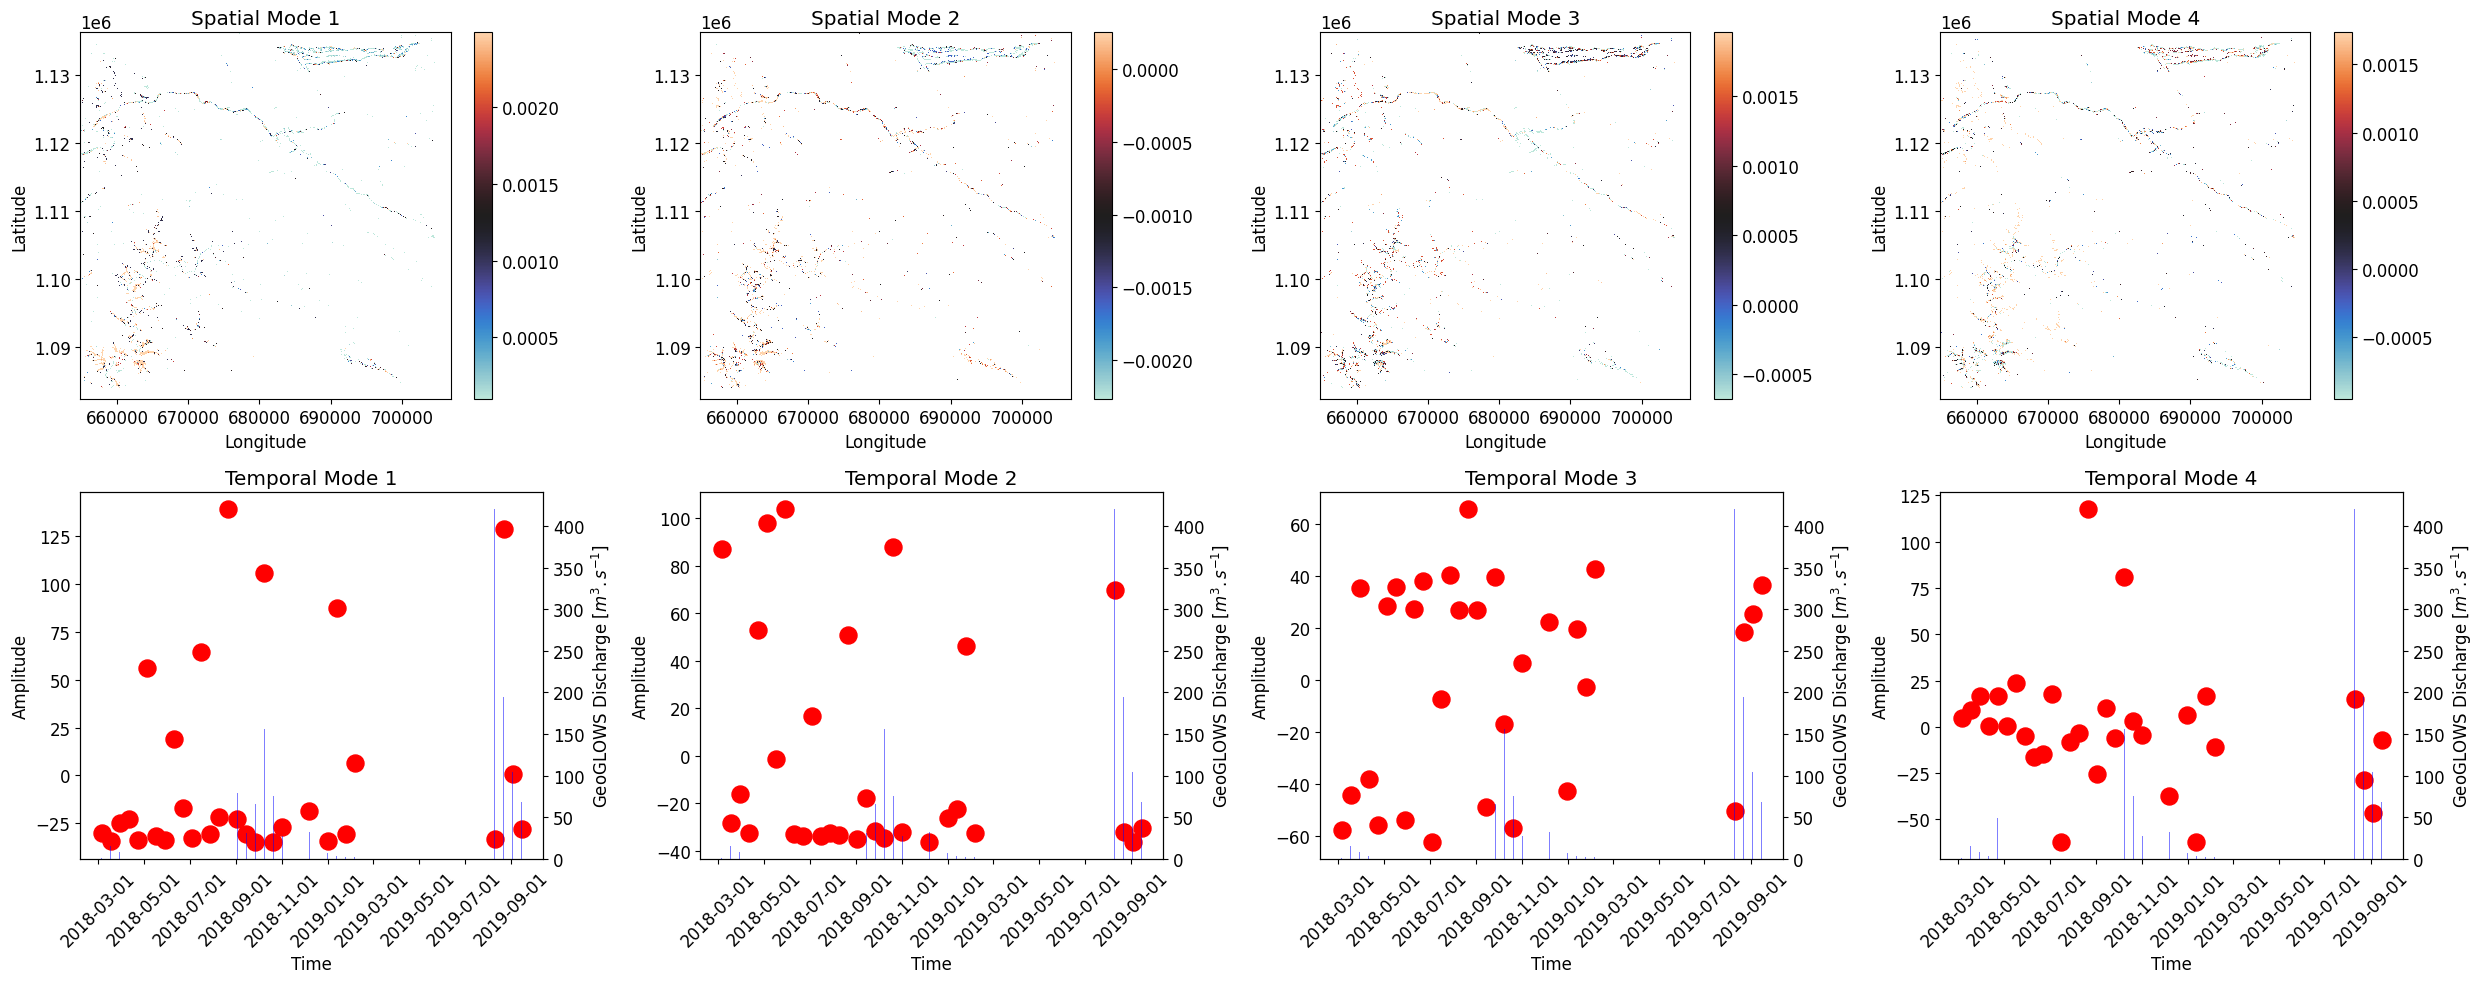

In [13]:
reof_ds.spatial_modes.values[reof_ds.spatial_modes.values==0]=np.nan

plt.figure()


fig, axes = plt.subplots(nrows=2, ncols=len(reof_ds.mode.values), figsize=(25, 10))

for i, ax in enumerate(axes[0]):

    # Create a plot of the spatial modes
    mesh = ax.pcolormesh(reof_ds.lon, reof_ds.lat, reof_ds.spatial_modes.values[:,:,i],
              cmap = 'icefire',
              vmin = -np.nanstd(reof_ds.spatial_modes.values[:,:,i])/2+np.nanmean(reof_ds.spatial_modes.values[:,:,i]),
              vmax = np.nanstd(reof_ds.spatial_modes.values[:,:,i])/2+np.nanmean(reof_ds.spatial_modes.values[:,:,i]))

    # Set plot title and labels
    ax.set_title(f"Spatial Mode {i+1}")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
                      
    # Add colorbar
    cbar = fig.colorbar(mesh, ax=ax)


for i, ax in enumerate(axes[1]):
    # Create a line plot of the temporal mode
    ax.scatter(times[:-nb_slices], reof_ds.temporal_modes[:, i], color = 'red', label='Temporal Modes', s = 150)
    # Format x-tick labels as dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_minor_locator(mdates.AutoDateLocator())
    # Rotate x-tick labels
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    # Set plot title and labels
    ax.set_title(f"Temporal Mode {i + 1}")
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

    # Create a secondary y-axis on the right
    ax_secondary = ax.twinx()

    # Plot the secondary data as bars on the right axis
    ax_secondary.bar(times[:-nb_slices], q_sel.values, color='blue', alpha=0.5, label = 'Discharge')
    ax_secondary.set_ylabel('GeoGLOWS Discharge [$m^{3}.s^{-1}$]')


plt.savefig(pathfig/f"SpatiotempModes_{times[0].strftime('%Y-%m-%d')}_{times[-1].strftime('%Y-%m-%d')}_{SAR_WaterMask.value}_{polarization_choice.value}.png", dpi = 400)
plt.tight_layout()
plt.show()

<hr>

# **Calculate the forecast of flooding based on the relationship between discharge and the main modes of our dataset**

In [27]:
# Choose the amount of days for the forecast
nb_days_forecast = 30

In [28]:
# Calculate the fits of different polynomials concerning each main mode
fits = fierpy.find_fits(reof_ds.fillna(0),q_sel,da_no_nans[:-nb_slices])
# Grab the best fitting mode and coefficients
_,mode,coeffs = sel_best_fit(fits, metric='rmse', ranking='min')

# Generate new dates array nb_days_forecast days into the future and save them as a dataset
forecast_dates = xr.Dataset.from_dataframe(
                    pd.DataFrame(
                        {'time': da[:-nb_slices].time.max().values +
                         np.arange(1, nb_days_forecast, dtype='timedelta64[D]')}
                    )
                    )

# Grab the GeoGLOWS forecast
q_forecast = fierpy.match_dates(q[0],forecast_dates)

# Use the previously found relationships and functions to generate RTC/mask forecast
forecast = fierpy.synthesize(reof_ds, q_forecast, np.poly1d(coeffs), mode)


In [29]:
# Get the matching indices
ind_precast = np.where(np.isin(da_comp['time'].values,forecast['time'].values))[0]
ind_forecast = np.where(np.isin(forecast['time'].values,da_comp['time'].values))[0]

# Grab the slices of the datasets corresponding to the matching indices
forecast_slice = forecast.isel(time=ind_forecast)
da_slice = da_comp.isel(time=ind_precast)

# Calculate the difference between the slices
difference = forecast_slice - da_slice


In [34]:
difference

<xarray.DataArray (time: 2, lat: 2700, lon: 2600)>
array([[[ 1.0258687e-14, -1.8531617e-14,  2.2436161e-14, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[ 8.4911656e-15, -1.5338710e-14,  1.8570521e-14, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2019-09-27 2019-10-09
  * lon          (lon) float64 6.549e+05 6.549e+05 ... 7.068e+05 7.068e+05
  * lat          (lat) float64 1.136e+06 1.136e+06 ... 1.082e+06 1.082e+06
    spatial_ref  int64 0

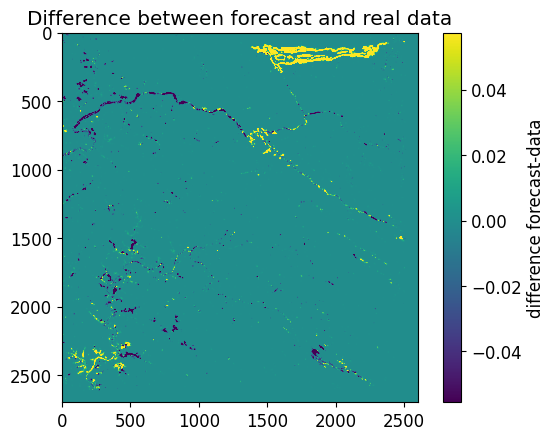

In [62]:
# Plot the average difference between forecast and data, save figure
plt.imshow(np.nanmean(difference.values, axis = 0),
           vmin = -np.nanstd(difference)+np.nanmean(difference),
           vmax = np.nanstd(difference)+np.nanmean(difference))
plt.colorbar(label='difference forecast-data')
plt.title('Difference between forecast and real data')
plt.savefig(pathfig/f"Diff_forecast_data_{times[-nb_slices:][ind_precast][0].strftime('%Y-%m-%d')}_{times[-nb_slices:][ind_precast][-1].strftime('%Y-%m-%d')}_{SAR_WaterMask.value}_{polarization_choice.value}.png", dpi = 400)


**Calculate some statistics**

In [37]:
from scipy.stats import ttest_ind
# Calculate means
mean_forecast = np.nanmean(forecast_slice.values)
mean_da_comp = np.nanmean(da_slice.values)

# Calculate standard deviations
std_forecast = np.nanstd(forecast_slice.values)
std_da_comp = np.nanstd(da_slice.values)

# Calculate correlation coefficient
valid_mask = np.isfinite(forecast_slice.values) & np.isfinite(da_slice.values)
correlation = np.corrcoef(forecast_slice.values[valid_mask], da_slice.values[valid_mask])[0, 1]

# Calculate quantiles
quantiles_forecast = np.percentile(forecast_slice.fillna(0), [25, 50, 75])
quantiles_da_comp = np.percentile(da_slice.fillna(0), [25, 50, 75])

# Perform t-test
t_stat, p_value = ttest_ind(forecast_slice.fillna(0).values.flatten(), da_slice.fillna(0).values.flatten())

# Print results
print("Mean of forecast_slice:", mean_forecast)
print("Mean of da_slice:", mean_da_comp)
print("Standard Deviation of forecast_slice:", std_forecast)
print("Standard Deviation of da_slice:", std_da_comp)
print("Correlation coefficient between forecast_slice and da_slice:", correlation)
print("Quantiles of forecast_slice:", quantiles_forecast)
print("Quantiles of da_slice:", quantiles_da_comp)
print("T-statistic:", t_stat)
print("P-value:", p_value)


Mean of forecast_slice: 0.015638813
Mean of da_slice: 0.014707763532763533
Standard Deviation of forecast_slice: 0.116589025
Standard Deviation of da_slice: 0.12038041877576212
Correlation coefficient between forecast_slice and da_slice: 0.886903254511002
Quantiles of forecast_slice: [0. 0. 0.]
Quantiles of da_slice: [0. 0. 0.]
T-statistic: 20.817258853555465
P-value: 3.0248073053202524e-96


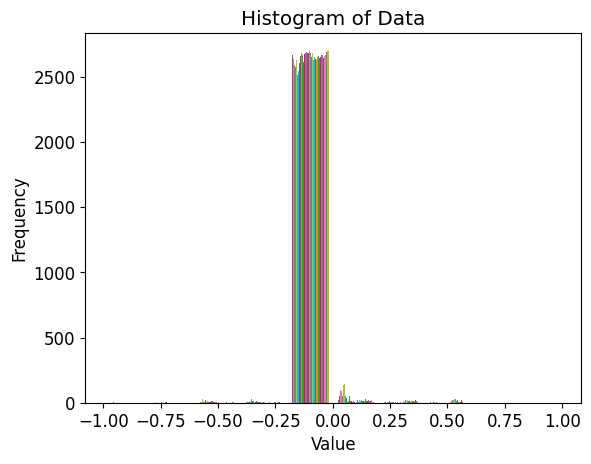

<Figure size 640x480 with 0 Axes>

In [63]:
# Plot the histogram of values
plt.hist(np.nanmean(difference.fillna(0).values, axis = 0), bins=10)  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.show()
plt.savefig(pathfig/f"Histogram_difference_{times[-nb_slices:][ind_precast][0].strftime('%Y-%m-%d')}_{times[-nb_slices:][ind_precast][-1].strftime('%Y-%m-%d')}_{SAR_WaterMask.value}_{polarization_choice.value}.png", dpi = 400)
